Importing Necessary Labraries

In [72]:
import nltk
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import twitter_samples, stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import re, string, random
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from google.colab import drive
import matplotlib.pyplot as plt
import math
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet, LinearRegression
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from imblearn.pipeline import Pipeline
import joblib
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from sklearn.linear_model import SGDRegressor
from sklearn.svm import SVR
import plotly.graph_objs as go
import plotly.figure_factory as ff
from bs4 import BeautifulSoup
from sklearn.neural_network import MLPRegressor
from nltk.tag import pos_tag

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('twitter_samples')
nltk.download('omw-1.4')
nltk.download('vader_lexicon')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package twitter_samples to /root/nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

Reading Datasets as Dataframes

In [73]:
Name = "AMZN"
stocks_df = pd.read_csv('/content/drive/MyDrive/Stock_Prediction/'+Name+'(stockdata2).csv')
tweets_df = pd.read_csv('/content/drive/MyDrive/Stock_Prediction/'+Name+'(tweets).csv', dtype="string", encoding='latin1')

Data Pre-Processing

In [74]:
#Creating function to clean tweets
def cleaner(tweet_tokens):
    soup = BeautifulSoup(tweet_tokens, 'lxml') # removing HTML entities such as â€˜&ampâ€™,â€™&quotâ€™,'&gt'; lxml is the html parser and shoulp be installed using 'pip install lxml'
    souped = soup.get_text()
    re1 = re.sub('RT @[\w_]+: ', '', souped)
    re2 = re.sub(r"(@|http://|https://|www|\\x)\S*", " ", re1) # substituting @mentions, urls, etc with whitespace
    re3 = re.sub("[^A-Za-z]+"," ", re2) # substituting any non-alphabetic character that repeats one or more times with whitespace

    tokens = nltk.word_tokenize(re3)
    lower_case = [t.lower() for t in tokens]

    stop_words = set(stopwords.words('english'))
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case))

    wordnet_lemmatizer = WordNetLemmatizer()
    lemmas = [wordnet_lemmatizer.lemmatize(t) for t in filtered_result]
    return lemmas

In [75]:
#Naming index column for both datasets 'Date'
col1 = tweets_df.columns[0]
tweets_df.rename(columns={col1:'Date'}, inplace=True)

In [76]:
#Transforming index columns to same format on both datasets
tweets_df['Date'] = pd.to_datetime(tweets_df['Date'])
stocks_df['Date'] = pd.to_datetime(stocks_df['Date'])

In [77]:
#Dropping days from tweets df that are on weekends and holidays because the stock market is only open on weekdays - With Date
tweets_dropped1 = pd.merge(stocks_df["Date"], tweets_df, on="Date")

In [78]:
#Dropping days from tweets df that are on weekends and holidays because the stock market is only open on weekdays - Without Date
tweets_dropped = pd.merge(stocks_df["Date"], tweets_df, on="Date").drop(columns=["Date"])

In [79]:
#Applying cleaner function to tweets
tweets_cleaned = tweets_dropped.applymap(lambda x: cleaner(x) if not pd.isnull(x) else x)

In [80]:
#Reconstructing sentences
from nltk.tokenize.treebank import TreebankWordDetokenizer
twd =TreebankWordDetokenizer()

reconstructedSentence = tweets_cleaned.applymap(lambda z: twd.detokenize(z) if not pd.isnull([z]).any() else z)

Sentiment Analysis with VADER

In [81]:
#Importing packages
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sent = SentimentIntensityAnalyzer()

In [82]:
#Creating empty dataframe
df1 = pd.DataFrame()

In [83]:
#Assigning sentiment scores of cleaned tweets on empty dataframe
df1 = reconstructedSentence.applymap(lambda x: round(sent.polarity_scores(x)['compound'], 2) if not pd.isnull([x]).any() else x)

In [84]:
#Calculating sentiment scores on a given day as the mean of al compound scores
sentiment_score = df1.mean(axis=1)

In [85]:
#Concatanating mean compund scores with preserved dates
df2 = pd.DataFrame(sentiment_score)
df2 = pd.concat([tweets_dropped1['Date'],df2],axis=1)
df2.columns = ['Date',  'Mean Compound Score']

df2.head()

,Date,Mean Compound Score
0,2015-07-01,0.254557
1,2015-07-02,0.309016
2,2015-07-06,0.301000
3,2015-07-07,0.192456
4,2015-07-09,0.390000


In [86]:
#Assigning labels to sentiment score
def condition(x):
  if x > 0:
    return "Positive"
  elif x==0:
    return "Neutral"
  else:
    return 'Negative'

df2['Sentiment'] = df2['Mean Compound Score'].apply(condition)
df2.head()

,Date,Mean Compound Score,Sentiment
0,2015-07-01,0.254557,Positive
1,2015-07-02,0.309016,Positive
2,2015-07-06,0.301000,Positive
3,2015-07-07,0.192456,Positive
4,2015-07-09,0.390000,Positive


Text(0.5, 0, 'Number of Tweets')

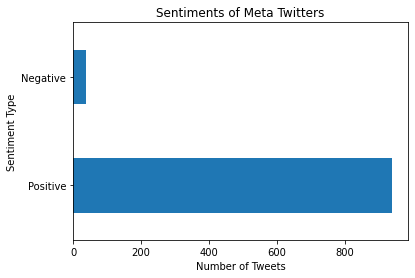

In [87]:
#Visualizing Sentiment Analysis Results
from matplotlib import pyplot as plt
df2['Sentiment'].value_counts().plot(kind="barh")
plt.title("Sentiments of Meta Twitters")
plt.ylabel("Sentiment Type")
plt.xlabel("Number of Tweets")

In [88]:
#Assigning numbers to sentiment labels
df2['Sentiment'] = df2['Sentiment'].replace({'Positive':1,'Neutral':2,'Negative':3})
df2['Sentiment'].value_counts()

1    938
3     38
Name: Sentiment, dtype: int64

Calculating Stock Returns

In [89]:
#Calculating Stock Returns
stocks_df['Return'] = stocks_df['Adj Close'].pct_change()
stocks_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return
0,2015-07-01,21.967501,22.000000,21.778999,21.869499,21.869499,39742000,NaN
1,2015-07-02,21.850000,21.910000,21.674000,21.885500,21.885500,26868000,0.000732
2,2015-07-06,21.761499,21.986500,21.676001,21.802000,21.802000,38064000,-0.003815
3,2015-07-07,21.784000,21.886499,21.278500,21.836000,21.836000,69084000,0.001559
4,2015-07-08,21.717501,21.799500,21.441500,21.485001,21.485001,47662000,-0.016074


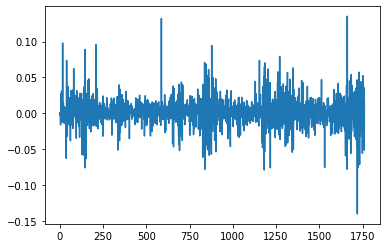

In [90]:
#Plotting Return
stocks_df['Return'].dropna().plot()

In [91]:
#Creating Function to check for stationarity
from statsmodels.tsa.stattools import adfuller

def adf(x):
  res = adfuller(x)
  print('Test-Statistic:', res[0])
  print('p-value:', res[1])
  if res[1] < 0.05:
    print('Stationary')
  else:
    print('Non-Stationary')

In [92]:
#Checking for Stationarity in Stock Prices
adf(stocks_df['Adj Close'].dropna())

Test-Statistic: -1.3696723421289385
p-value: 0.596726158979469
Non-Stationary


In [93]:
#Checking for Stationarity in Stock Returns
adf(stocks_df['Return'].dropna())

Test-Statistic: -14.1503431905416
p-value: 2.1674274842931954e-26
Stationary


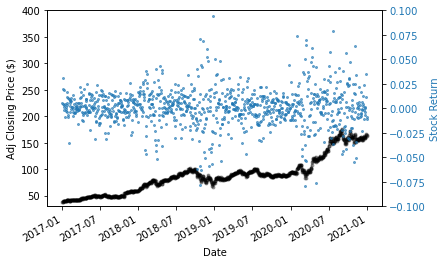

In [94]:
#Plotting the stocks closing price vs the return 
fig, ax2 = plt.subplots()

color = 'black'
ax2 = stocks_df.set_index('Date').loc['01-2017':'12-2020', 'Adj Close'].plot(marker='.', alpha=0.3, linestyle='-', color=color , linewidth=2, label='test')
ax2.set_ylabel('Adj Closing Price ($)', color=color)
ax2.tick_params(axis='y')
ax2.set_ylim(30,400) 

ax = ax2.twinx()
color = 'tab:blue'
ax = stocks_df.set_index('Date').loc['01-2017':'12-2020', 'Return'].plot(marker='o', alpha=0.6, linestyle='-', color=color, linewidth=0, markersize=2)
ax.set_xlabel('Date')
ax.set_ylabel('Stock Return', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim(-0.1,0.1)

fig.show();

Creating Final Dataset: Merging Tweets with Stocks Dataframe

In [95]:
#Merging Dataframes
dataset = pd.merge(stocks_df, df2, on='Date', how='left')
dataset = dataset.replace(np.nan,0)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Return,Mean Compound Score,Sentiment
0,2015-07-01,21.967501,22.000000,21.778999,21.869499,21.869499,39742000,0.000000,0.254557,1.0
1,2015-07-02,21.850000,21.910000,21.674000,21.885500,21.885500,26868000,0.000732,0.309016,1.0
2,2015-07-06,21.761499,21.986500,21.676001,21.802000,21.802000,38064000,-0.003815,0.301000,1.0
3,2015-07-07,21.784000,21.886499,21.278500,21.836000,21.836000,69084000,0.001559,0.192456,1.0
4,2015-07-08,21.717501,21.799500,21.441500,21.485001,21.485001,47662000,-0.016074,0.000000,0.0


In [97]:
#Setting Index to Date Column
dataset = dataset.set_index('Date')

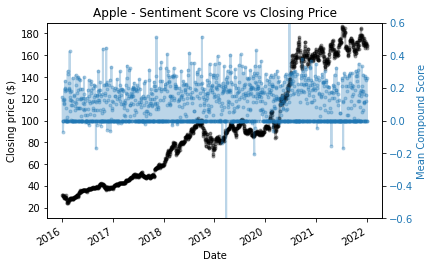

In [98]:
#Plotting the stocks closing price vs sentiment
fig2, ax3 = plt.subplots()

color = 'black'
ax3 = dataset.loc['01-2016':'12-2021', 'Adj Close'].plot(marker='.', alpha=0.3, linestyle='-', color=color , linewidth=2, label='Close Price')
ax3.set_ylabel('Closing price ($)', color=color)
ax3.tick_params(axis='y')
ax3.set_ylim(10,190) 

ax = ax3.twinx()
color = 'tab:blue'
ax = dataset.loc['01-2016':'12-2021', 'Mean Compound Score'].plot(marker='.', alpha=0.3, linestyle='-', color=color, linewidth=2)
ax.set_xlabel('Date')
ax.set_ylabel('Mean Compound Score', color=color)
ax.tick_params(axis='y', labelcolor=color)
ax.set_ylim(-0.6, 0.6)

plt.title('Apple - Sentiment Score vs Closing Price')

fig.show();

In [99]:
#Dropping Unnecessary Columns
final_df = dataset.drop(columns=["Open", "High", "Low", "Close", "Volume"])
final_df.head()

,Adj Close,Return,Mean Compound Score,Sentiment
Date,,,,
2015-07-01,21.869499,0.000000,0.254557,1.0
2015-07-02,21.885500,0.000732,0.309016,1.0
2015-07-06,21.802000,-0.003815,0.301000,1.0
2015-07-07,21.836000,0.001559,0.192456,1.0
2015-07-08,21.485001,-0.016074,0.000000,0.0


In [100]:
#Exploring Final Dataset
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1762 entries, 2015-07-01 to 2022-06-29
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Adj Close            1762 non-null   float64
 1   Return               1762 non-null   float64
 2   Mean Compound Score  1762 non-null   float64
 3   Sentiment            1762 non-null   float64
dtypes: float64(4)
memory usage: 133.4 KB


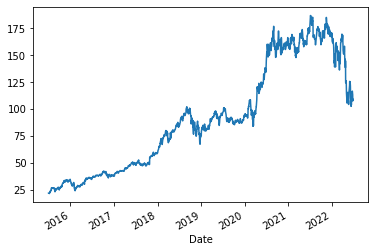

In [101]:
#Visualizing Target Column
final_df['Adj Close'].plot()

In [102]:
#Plotting Correlation Heatmap
corrs = final_df.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)
figure.show()

In [103]:
#Creating Rolling Window Function
def window_data(df, window, feature_col_number1, feature_col_number2, feature_col_number3, feature_col_number4, target_col_number):
    # Create empty lists for target and features
    X_Close = []
    X_Return = []
    X_Compound = []
    X_Sentiment = []
    y = []
    for i in range(len(df) - window):
        
        # Get close, return, polarity, sentiment, and target in the loop
        Close = df.iloc[i:(i + window), feature_col_number1]
        Return = df.iloc[i:(i + window), feature_col_number2]
        Compound = df.iloc[i:(i + window), feature_col_number3]
        Sentiment = df.iloc[i:(i + window), feature_col_number4]
        target = df.iloc[(i + window), target_col_number]
        
        # Append values in the lists
        X_Close.append(Close)
        X_Return.append(Return)
        X_Compound.append(Compound)
        X_Sentiment.append(Sentiment)
        y.append(target)
        
    return np.hstack((X_Close, X_Return, X_Compound, X_Sentiment)), np.array(y).reshape(-1, 1)

In [104]:
#Setting Window Size
window_size = 4

feature_col_number1 = 0
feature_col_number2 = 1
feature_col_number3 = 2
feature_col_number4 = 3
target_col_number = 0
X, y = window_data(final_df, window_size, feature_col_number1, feature_col_number2, feature_col_number3, feature_col_number4, target_col_number)

In [105]:
X

array([[ 21.869499,  21.8855  ,  21.802   , ...,   1.      ,   1.      ,
          1.      ],
       [ 21.8855  ,  21.802   ,  21.836   , ...,   1.      ,   1.      ,
          0.      ],
       [ 21.802   ,  21.836   ,  21.485001, ...,   1.      ,   0.      ,
          1.      ],
       ...,
       [108.68    , 108.949997, 112.440002, ...,   0.      ,   1.      ,
          1.      ],
       [108.949997, 112.440002, 116.459999, ...,   1.      ,   1.      ,
          1.      ],
       [112.440002, 116.459999, 113.220001, ...,   1.      ,   1.      ,
          1.      ]])

In [106]:
y

array([[ 21.485001],
       [ 21.7195  ],
       [ 22.175501],
       ...,
       [113.220001],
       [107.400002],
       [108.919998]])

In [107]:
#Split data into 80% for training and the remainder for testing
X_split = int(0.8 * len(X))
y_split = int(0.8 * len(y))

X_train = X[: X_split]
X_test = X[X_split:]
y_train = y[: y_split]
y_test = y[y_split:]

In [108]:
# Use the MinMaxScaler to scale data into the same ranges.
x_train_scaler = MinMaxScaler()
x_test_scaler = MinMaxScaler()
y_train_scaler = MinMaxScaler()
y_test_scaler = MinMaxScaler()

# Fit the scaler for the Training Data
x_train_scaler.fit(X_train)
y_train_scaler.fit(y_train)

# Scale the training data
X_train = x_train_scaler.transform(X_train)
y_train = y_train_scaler.transform(y_train)

# Fit the scaler for the Testing Data
x_test_scaler.fit(X_test)
y_test_scaler.fit(y_test)

# Scale the y_test data
X_test = x_test_scaler.transform(X_test)
y_test = y_test_scaler.transform(y_test)

Random Forest Regressor

In [109]:
#Creating the RFR Boost regressor instance
rfr = RandomForestRegressor()
rfr.fit(X_train, y_train.ravel())
predicted = rfr.predict(X_test)

#Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

#Creating a DataFrame of Real and Predicted values
stocks_rfr = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 

stocks_rfr.head()

Root Mean Squared Error: 0.04772521541590704
R-squared : 0.956594607822214


,Real,Predicted
Date,,
2021-02-05,167.607498,168.594817
2021-02-08,166.147003,169.321331
2021-02-09,165.250000,169.410241
2021-02-10,164.328995,168.299809
2021-02-11,163.106506,167.816984


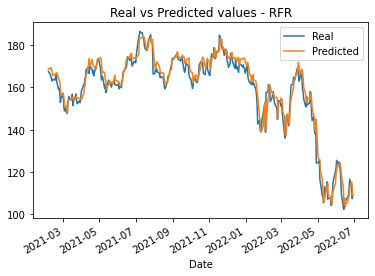

In [110]:
#Plotting Real vs Predicted Values
stocks_rfr.plot(title = "Real vs Predicted values - RFR")

XGBoost Regressor

In [111]:
#Creating the XG Boost regressor instance
xgboost = XGBRegressor()
xgboost.fit(X_train, y_train.ravel())
predicted = xgboost.predict(X_test)

# Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

#Creating a DataFrame of Real and Predicted values
stocks_xgbr = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 
stocks_xgbr.head()

[12:44:13] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Root Mean Squared Error: 0.04707329474215594
R-squared : 0.9577723335313177


,Real,Predicted
Date,,
2021-02-05,167.607498,167.432388
2021-02-08,166.147003,169.768265
2021-02-09,165.250000,169.713348
2021-02-10,164.328995,165.012131
2021-02-11,163.106506,165.151611


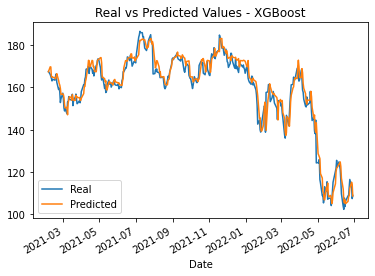

In [112]:
#Plotting Real vs Predicted Values
stocks_xgbr.plot(title = "Real vs Predicted Values - XGBoost")

Linear Regression 

In [113]:
#Creating the Linear regressor instance
lr = LinearRegression()
lr.fit(X_train, y_train.ravel())
predicted = lr.predict(X_test)

#Evaluating the model
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))
predicted_prices = y_test_scaler.inverse_transform(predicted.reshape(-1, 1))
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

#Creating a DataFrame of Real and Predicted values
stocks_lr = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 
stocks_lr.head()

Root Mean Squared Error: 0.04127835420840823
R-squared : 0.9675292263213169


,Real,Predicted
Date,,
2021-02-05,167.607498,166.399347
2021-02-08,166.147003,168.255163
2021-02-09,165.250000,166.357409
2021-02-10,164.328995,165.552424
2021-02-11,163.106506,165.171348


In [114]:
lr.fit(X_train, y_train.ravel())
print('Intercept', lr.intercept_)
print(pd.DataFrame(zip(final_df.columns, lr.coef_), columns=['Features','Coefficients']).sort_values(by=['Coefficients'],ascending=False))


Intercept -0.0052220848213914706
              Features  Coefficients
3            Sentiment      0.913881
0            Adj Close      0.202775
2  Mean Compound Score      0.081890
1               Return     -0.197669


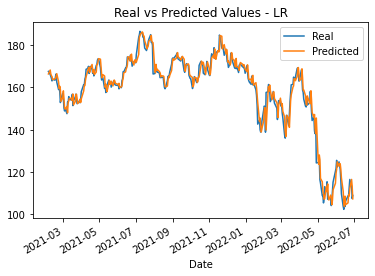

In [115]:
#Plotting Real vs Predicted Values
stocks_lr.plot(title = "Real vs Predicted Values - LR")

LSTM RNN Model

In [116]:
#Reshaping the features for the model
X_train_ = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_ = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [117]:
#Defining the LSTM RNN model.
lstm = Sequential()

number_units = 9
dropout_fraction = 0.2

# Layer 1
lstm.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train_.shape[1], 1))
    )
    
lstm.add(Dropout(dropout_fraction))

# Layer 2
# The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer.
lstm.add(LSTM(units=number_units, return_sequences=True))
lstm.add(Dropout(dropout_fraction))

# Layer 3
lstm.add(LSTM(units=number_units))
lstm.add(Dropout(dropout_fraction))

# Output layer
lstm.add(Dense(1))

In [118]:
lstm.compile(optimizer="adam", loss="mean_squared_error")

In [119]:
lstm.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 16, 9)             396       
                                                                 
 dropout_3 (Dropout)         (None, 16, 9)             0         
                                                                 
 lstm_4 (LSTM)               (None, 16, 9)             684       
                                                                 
 dropout_4 (Dropout)         (None, 16, 9)             0         
                                                                 
 lstm_5 (LSTM)               (None, 9)                 684       
                                                                 
 dropout_5 (Dropout)         (None, 9)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [120]:
history = lstm.fit(X_train_, y_train, epochs=25, shuffle=False, batch_size=8, verbose=1)

Epoch 1/20
176/176 [==============================] - 5s 7ms/step - loss: 0.0100
Epoch 2/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0359
Epoch 3/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0582
Epoch 4/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0660
Epoch 5/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0535
Epoch 6/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0344
Epoch 7/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0153
Epoch 8/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0098
Epoch 9/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0075
Epoch 10/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0076
Epoch 11/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0076
Epoch 12/20
176/176 [==============================] - 1s 7ms/step - loss: 0.0066
Epoch 13/20
176/176 [====

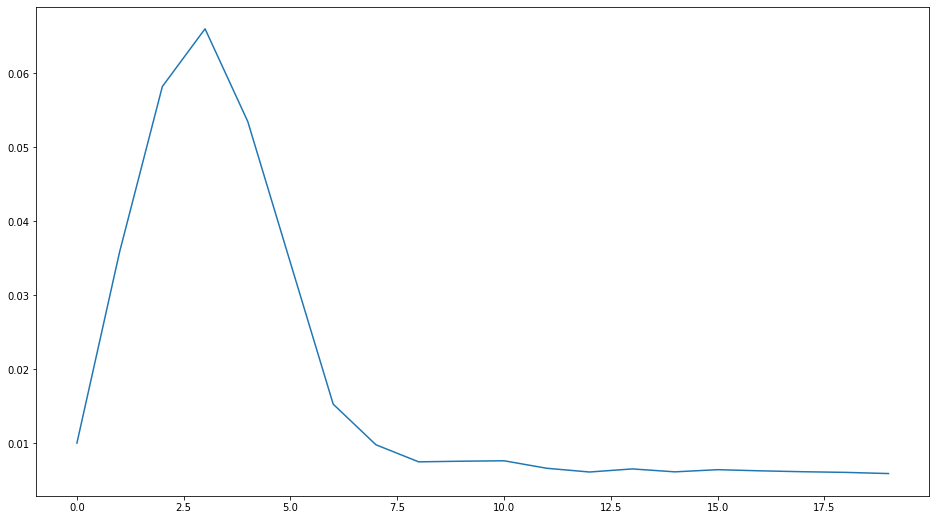

In [121]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])

In [122]:
lstm.evaluate(X_test_, y_test)
predicted = lstm.predict(X_test_)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

stocks_lstm = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 
stocks_lstm.head()

11/11 [==============================] - 1s 3ms/step - loss: 0.0346
Root Mean Squared Error: 0.1861325622882084
R-squared : 0.33977403264411643


,Real,Predicted
Date,,
2021-02-05,167.607498,179.617188
2021-02-08,166.147003,179.371109
2021-02-09,165.250000,179.139801
2021-02-10,164.328995,179.229584
2021-02-11,163.106506,178.931961


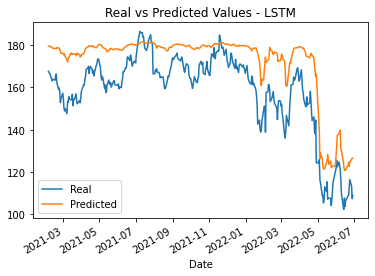

In [123]:
stocks_lstm.plot(title = "Real vs Predicted Values - LSTM")

BiLSTM

In [124]:
model = tf.keras.models.Sequential([
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200, return_sequences=True), 
                                input_shape=(X_train.shape[1], 1)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(150)),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dense(20, activation='tanh'),
     tf.keras.layers.Dropout(0.25),
     tf.keras.layers.Dense(units=1),
 ])
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 16, 400)          323200    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 16, 20)            8020      
                                                                 
 bidirectional_1 (Bidirectio  (None, 300)              205200    
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 20)                6020      
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dropout_6 (Dropout)         (None, 20)               

In [125]:
history = model.fit(X_train, y_train, epochs=25, shuffle=False, batch_size=32, verbose=1)

Epoch 1/25
44/44 [==============================] - 7s 11ms/step - loss: 0.0152
Epoch 2/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0473
Epoch 3/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0788
Epoch 4/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0976
Epoch 5/25
44/44 [==============================] - 0s 11ms/step - loss: 0.1236
Epoch 6/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0855
Epoch 7/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0696
Epoch 8/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0516
Epoch 9/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0153
Epoch 10/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0058
Epoch 11/25
44/44 [==============================] - 1s 11ms/step - loss: 0.0055
Epoch 12/25
44/44 [==============================] - 0s 11ms/step - loss: 0.0037
Epoch 13/25
44/44 [==================

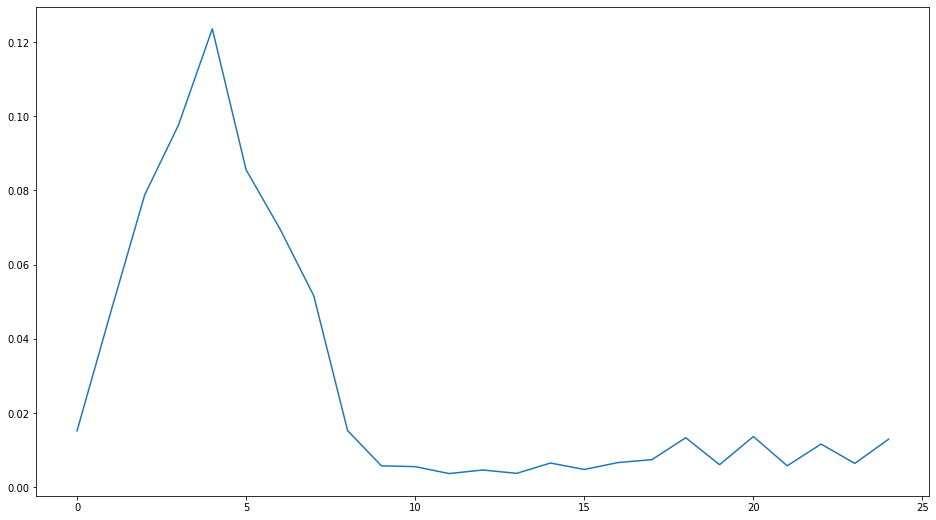

In [126]:
plt.figure(figsize=(16,9))
plt.plot(history.history['loss'])

In [127]:
model.evaluate(X_test, y_test)
predicted = model.predict(X_test)
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, predicted)))
print('R-squared :', metrics.r2_score(y_test, predicted))

predicted_prices = y_test_scaler.inverse_transform(predicted)
real_prices = y_test_scaler.inverse_transform(y_test.reshape(-1, 1))

stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
}, index = final_df.index[-len(real_prices): ]) 
stocks.head()

11/11 [==============================] - 1s 5ms/step - loss: 0.0124
Root Mean Squared Error: 0.1114195357958801
R-squared : 0.7634240572952399


,Real,Predicted
Date,,
2021-02-05,167.607498,159.544495
2021-02-08,166.147003,158.245407
2021-02-09,165.250000,157.990036
2021-02-10,164.328995,159.545105
2021-02-11,163.106506,158.753067


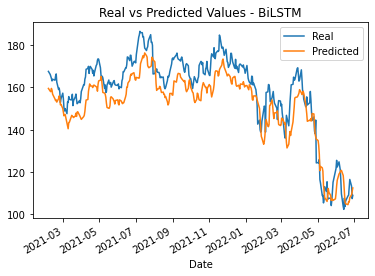

In [128]:
stocks.plot(title = "Real vs Predicted Values - BiLSTM")